In [1]:
import glob
import sys
import numpy as np
import pandas as pd
import ipyparallel as p

In [9]:
c = p.Client()

In [10]:
c.ids

[0, 1, 2, 3, 4, 5]

In [11]:
view = c.load_balanced_view()

In [12]:
%%px
# define the objective functions from Bart et al. 2016

#NSE
def NSE(obs,mod):
       
    return 1. - (np.nansum(np.square(obs-mod)) / np.nansum(np.square(obs - np.nanmean(obs))))

                 
def NSE_log(obs,mod):
    
    obs = np.log10(obs)
    
    mod[mod<=0] = np.NaN
    
    mod = np.log10(mod)
    
    return 1. - (np.nansum(np.square(obs-mod)) / np.nansum(np.square(obs - np.nanmean(obs))))

def PE(obs,mod):
    
    return (np.nanmean(mod)-np.nanmean(obs))/np.nanmean(obs)

def RMSE(obs,mod):
    return np.sqrt(np.nanmean(np.square(mod-obs)))

def OBFX(obs,mod):
    
    pe = PE(obs,mod)
    nse = NSE(obs,mod)
    nse_log = NSE_log(obs,mod)
    rmse = RMSE(obs,mod)
    
    obfx = nse*nse_log*(1.-np.abs(pe))
    
    return pe,nse,nse_log,rmse

def parse_rhessys_date(df):
    return '%s-%s-%s'%(int(df.year),int(df.month),int(df.day))

strt = '2004-10-01'
nd = '2007-09-30'

obs = pd.read_pickle('/RHESSys/Como/obs/como_q_obs.pcl')[strt:nd].discharge.as_matrix()
#obs[obs==0.051806] = np.NaN

In [13]:
# define the objective functions from Bart et al. 2016

#NSE
def NSE(obs,mod):
       
    return 1. - (np.nansum(np.square(obs-mod)) / np.nansum(np.square(obs - np.nanmean(obs))))

                 
def NSE_log(obs,mod):
    
    obs = np.log10(obs)
    
    mod[mod<=0] = np.NaN
    
    mod = np.log10(mod)
    
    return 1. - (np.nansum(np.square(obs-mod)) / np.nansum(np.square(obs - np.nanmean(obs))))

def PE(obs,mod):
    
    return (np.nanmean(mod)-np.nanmean(obs))/np.nanmean(obs)

def RMSE(obs,mod):
    return np.sqrt(np.nanmean(np.square(mod-obs)))

def OBFX(obs,mod):
    
    pe = PE(obs,mod)
    nse = NSE(obs,mod)
    nse_log = NSE_log(obs,mod)
    
    obfx = nse*nse_log*(1.-np.abs(pe))
    
    return pe,nse,nse_log

def parse_rhessys_date(df):
    return '%s-%s-%s'%(int(df.year),int(df.month),int(df.day))

strt = '2004-10-01'
nd = '2007-09-30'

obs = pd.read_pickle('/RHESSys/Como/obs/como_q_obs.pcl')[strt:nd].discharge.as_matrix()
#obs[obs==0.051806] = np.NaN

In [14]:
files = glob.glob('/RHESSys/Como/out/cal/cal14_*.npz')

In [15]:
len(files)

300

In [16]:
def reprocess(fl):
    idx = int(fl.split('/')[-1].split('_')[-1].split('.')[0])
    
    dat = np.load(fl)
    
    tmp = pd.DataFrame()
    
    for key in dat.keys():
        tmp[key] = dat[key]
        
    tmp.index = pd.DatetimeIndex(tmp.datetime)
    tmp['obs'] = obs
    tmp['wateryear'] = tmp.index.map(rut.wateryear)
    tmp.dropna(inplace=True)
    tmp = tmp.groupby(by='wateryear').sum()
    #tmp.loc[tmp.index == 2008] = np.NaN
    #tmp.loc[tmp.index == 2010] = np.NaN
    tmp.dropna(inplace=True)
    
    pe,nse,nse_log,rmse = OBFX(tmp.obs.as_matrix(),tmp.streamflow.as_matrix())
    
    return idx,pe,nse,nse_log,rmse

In [17]:
res = view.map(reprocess,files)

In [22]:
res.progress

300

In [23]:
idx,pe,nse,nse_log,rmse = zip(*res.result())

In [24]:
data = pd.DataFrame({'idx':idx,'pe':pe,'nse':nse,'nse_log':nse_log,'rmse':rmse})

In [25]:
data.sort_values(by='nse',ascending=False).head()

,idx,nse,nse_log,pe,rmse
256,6,-1.630010,-1.354692,0.060901,32.849155
258,61,-1.669801,-1.898035,-0.062536,33.096719
43,137,-1.832706,-1.888563,-0.026753,34.091512
270,72,-1.925504,-1.881321,0.008814,34.645422
196,275,-2.086579,-1.976539,0.002913,35.586410


In [65]:
def loadfl(idx,cal):
    fl = '/RHESSys/Como/out/cal/cal%s_%s.npz'%(cal,idx)
    
    dat = np.load(fl)
    
    tmp = pd.DataFrame()
    
    for key in dat.keys():
        tmp[key] = dat[key]
        
    tmp.index = pd.DatetimeIndex(tmp.datetime)
    tmp['obs'] = obs
    tmp['wateryear'] = tmp.index.map(rut.wateryear)
    tmp.dropna(inplace=True)
    tmp = tmp.groupby(by='wateryear').sum()
    tmp.loc[tmp.index == 2008] = np.NaN
    tmp.loc[tmp.index == 2010] = np.NaN
    tmp.dropna(inplace=True)
    
    return tmp

In [71]:
dat = loadfl(85,14)

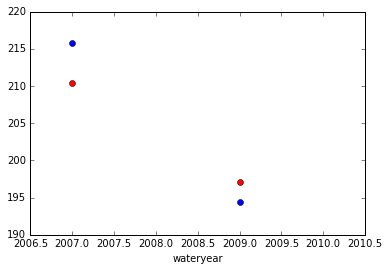

In [72]:
dat.streamflow.plot(marker='o',ls='')
dat.obs.plot(marker='o',ls='',c='r')
plt.xlim(2006.5,2010.5)
ax = plt.gca()
ax.get_xaxis().get_major_formatter().set_useOffset(False)

In [46]:
dat

,streamflow,rz_storage,lai,snowpack,snow_subl,sat_def,precip,sat_def_z,trans,returnflow,evap,baseflow,obs
wateryear,,,,,,,,,,,,,
2007,216.958817,632.275248,647.292326,1453.665913,38.638567,985.335940,759.901303,2383.841764,112.189280,126.098355,163.759962,90.860465,210.424486
2008,195.271577,627.046115,516.587319,1883.633154,22.815226,920.205010,632.140124,2223.225095,49.760392,119.996439,117.957188,75.275138,148.167204
2009,195.624752,739.498198,577.130314,1104.460279,40.950893,1086.227039,636.583992,2585.652573,82.092392,104.661388,149.139631,90.963363,197.100251
2010,180.974684,453.274121,620.612901,380.410807,30.763969,741.856410,644.360755,1786.088471,65.158321,99.517850,144.137094,81.456839,235.301302


In [49]:
dat.loc[dat.index == 2008] = np.NaN

In [50]:
dat

,streamflow,rz_storage,lai,snowpack,snow_subl,sat_def,precip,sat_def_z,trans,returnflow,evap,baseflow,obs
wateryear,,,,,,,,,,,,,
2007,216.958817,632.275248,647.292326,1453.665913,38.638567,985.335940,759.901303,2383.841764,112.189280,126.098355,163.759962,90.860465,210.424486
2008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009,195.624752,739.498198,577.130314,1104.460279,40.950893,1086.227039,636.583992,2585.652573,82.092392,104.661388,149.139631,90.963363,197.100251
2010,180.974684,453.274121,620.612901,380.410807,30.763969,741.856410,644.360755,1786.088471,65.158321,99.517850,144.137094,81.456839,235.301302
